### 运行前先装一个PyEMD库     是pip install pyemd pip install PyEMD，还是pip install EMD-signal 试着装哪个成功

In [1]:
# 调用相关库
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import numpy as np
import random
from sampen import sampen2 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from PyEMD import CEEMDAN, Visualisation
from scipy.io import savemat,loadmat
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame
from pandas import concat
import numpy
import keras.backend as K
from keras.callbacks import LearningRateScheduler
import os
import copy
import scipy as spy
import math

In [2]:
# 转换成监督数据，将每个特征转换成21列数据，20->1，20组预测一组
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  #计算特征的数量
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将20组输入数据依次向下移动20,19,...3,2,1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有21块经过下移后的数据(即：df(-20),df(-19),...df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # print(agg)
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
dataset = pd.read_excel("816480.xlsx")
fratures_Corrected_irradiance = [
    'Flow (Veh/5 Minutes)'
]
values = dataset[fratures_Corrected_irradiance].values
n_features=1 #特征数量

In [4]:
values = values.astype('float32')
close = values

In [5]:
close=close.reshape(-1,1)
close.shape

(1440, 1)

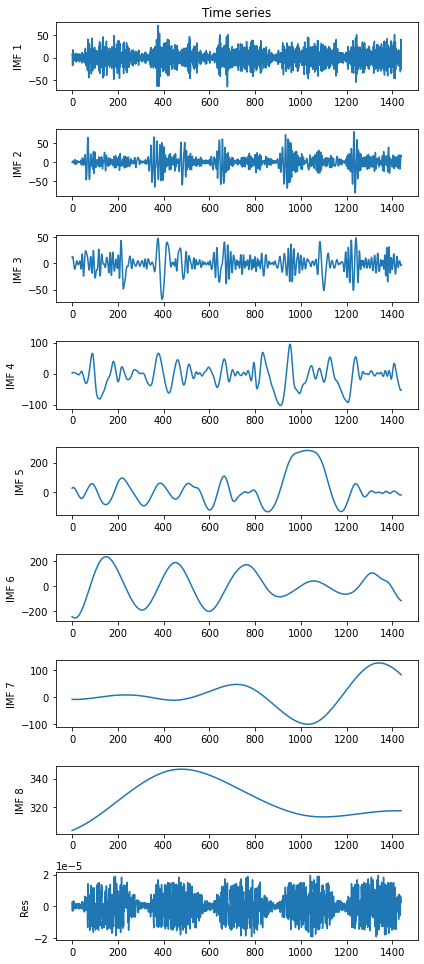

In [6]:
ceemdan = CEEMDAN()  
# ceemdan = CEEMDAN(trials = 500,epsilon = 0.3)   
ceemdan.ceemdan(close.reshape(-1))
imfs_close, res_close = ceemdan.get_imfs_and_residue()

t = np.arange(0, close.shape[0], 1)
vis = Visualisation()
vis.plot_imfs(imfs=imfs_close, residue=res_close, t=t, include_residue=True)
# vis.plot_instant_freq(t, imfs=imfs)
vis.show()

In [7]:
imfs_close_=imfs_close.T
imfs_close1=pd.DataFrame(imfs_close_)
res_close1=pd.DataFrame(res_close)
data_ = pd.concat((imfs_close1,res_close1), axis=1)   #组合分量和残差
data_.columns = ['imf'+str(i) for i in range(len(data_.columns))]
data_

,imf0,imf1,imf2,imf3,imf4,imf5,imf6,imf7,imf8
0,7.964262,-1.145149,11.377716,1.858538,28.879480,-242.777597,-9.217392,304.060144,-2.560366e-06
1,2.079726,0.720540,12.813558,2.540567,30.452936,-244.477692,-9.251811,304.122181,2.880713e-06
2,-17.681842,1.686095,13.389165,3.066223,31.677106,-246.037712,-9.283850,304.184814,1.369795e-07
3,17.294731,0.544685,12.716111,3.423325,32.542342,-247.455743,-9.313492,304.248043,-3.084615e-06
4,-15.741198,-0.894520,10.712188,3.632945,33.049312,-248.729873,-9.340722,304.311867,6.764485e-07
...,...,...,...,...,...,...,...,...,...
1435,-31.547515,-13.610808,1.129936,-51.491820,-17.216144,-111.184724,85.192499,317.728582,-5.705861e-06
1436,-30.736431,-2.190522,-1.429000,-52.754396,-17.401720,-112.616806,84.400335,317.728549,6.285674e-06
1437,10.491452,10.593503,-3.552587,-53.540479,-17.390734,-113.931963,83.602407,317.728410,5.822305e-06
1438,40.889504,18.053319,-4.374412,-53.800078,-17.168545,-115.126729,82.798772,317.728165,4.278541e-06


In [8]:
def permutation_entropy(df_ceemdan=None, mm=1, r=0.1): # 排列熵的计算; mm = 1 or 2; r = 0.1 or 0.2 
    np_sampen = []
    for i in range(len(df_ceemdan.columns)):
        sample_entropy = sampen2(list(df_ceemdan['imf'+str(i)].values),mm=mm,r=r,normalize=True)
        np_sampen.append(sample_entropy[1][1])
    df_pe = pd.DataFrame(np_sampen, index=['imf'+str(i) for i in range(len(df_ceemdan.columns))])
    return df_pe

             0
imf0  2.219547
imf1  2.143161
imf2  1.562538
imf3  0.546018
imf4  0.145774
imf5  0.120900
imf6  0.028686
imf7  0.017455
imf8  2.515859


<AxesSubplot:title={'center':'permutation Entropy'}>

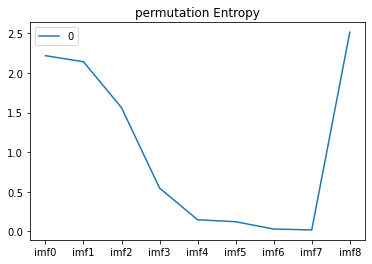

In [9]:
# 3.排列的计算
df_sampen = permutation_entropy(data_)
print(df_sampen)
df_sampen.plot(title='permutation Entropy')

### 熵重构

In [10]:
values1=data_.values
values1.shape

(1440, 9)

In [11]:
u=[]
ss1=values1[:,0]+values1[:,1]+values1[:,8]
u.append(ss1)
ss2=values1[:,2]+values1[:,3]
u.append(ss2)
ss3=values1[:,4]+values1[:,5]+values1[:,6]+values1[:,7]
u.append(ss3)

In [12]:
u=np.array(u)
u.shape

(3, 1440)

In [13]:
def implement_bigru(train_X, train_y):
    inputs=Input(shape=(train_X.shape[1], train_X.shape[2]))
    bigru=Bidirectional(GRU(128, activation='selu',return_sequences=False))(inputs)
    #dense=Dropout(dropout)(rnn)#droupout层
    outputs = Dense(1)(bigru)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile('adam','mse')
    model.summary()#展示模型结构
    return model

In [14]:
prediction_test = []
actual_test = []

for imf in u:
    imf=imf.reshape(-1,1)
    imf=pd.DataFrame(imf)
    data_=imf.values
    data_ = data_.astype('float32')
    # 标准化/放缩 特征值在（0,1）之间
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data_)
    
    n_in = 3
    n_out = 1
    # 构造一个20->1的监督学习型数据
    reframed = series_to_supervised(scaled, n_in=n_in, n_out=n_out)
    values=reframed.values
    
    #训练集和测试集的划分比例
    ratio=0.8 
    N=int(len(values) *ratio)
    train = values[:N, :]
    test = values[N:, :]
    
    # 划分输入和输出,split into input and outputs
    n_obs = n_in *  n_features
    train_X, train_y = train[:, :n_obs], train[:, n_obs:]
    test_X, test_y = test[:, :n_obs], test[:, n_obs:]

    # 将数据转换为3D输入，[samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_in, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_in, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    
        # In[] 参数设置
    tmp = implement_bigru(train_X, train_y)#建立模型
    history = tmp.fit(train_X, train_y, epochs=60, batch_size=30,validation_data=(test_X, test_y),verbose=2,
                    shuffle=False)
   
    
    
    
    #预测
    yhat = tmp.predict(test_X)
    yhat=yhat.reshape(-1,1)
    # 对预测结果进行反归一化
    inv_yhat = scaler.inverse_transform(yhat)
    prediction_test.append(inv_yhat)
    # 将真实列据进行反归一化
    test_y=test_y.reshape(-1,1)
    inv_y = scaler.inverse_transform(test_y)
    actual_test.append(inv_y)

(1149, 3, 1) (1149, 1) (288, 3, 1) (288, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              100608    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 100,865
Trainable params: 100,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
39/39 - 1s - loss: 0.9653 - val_loss: 1.0463 - 1s/epoch - 38ms/step
Epoch 2/60
39/39 - 0s - loss: 0.9211 - val_loss: 1.0476 - 83ms/epoch - 2ms/step
Epoch 3/60
39/39 - 0s - loss: 0.9109 - val_loss: 1

Epoch 20/60
39/39 - 0s - loss: 0.0157 - val_loss: 0.0282 - 78ms/epoch - 2ms/step
Epoch 21/60
39/39 - 0s - loss: 0.0153 - val_loss: 0.0276 - 79ms/epoch - 2ms/step
Epoch 22/60
39/39 - 0s - loss: 0.0148 - val_loss: 0.0269 - 77ms/epoch - 2ms/step
Epoch 23/60
39/39 - 0s - loss: 0.0144 - val_loss: 0.0264 - 76ms/epoch - 2ms/step
Epoch 24/60
39/39 - 0s - loss: 0.0140 - val_loss: 0.0257 - 77ms/epoch - 2ms/step
Epoch 25/60
39/39 - 0s - loss: 0.0136 - val_loss: 0.0251 - 77ms/epoch - 2ms/step
Epoch 26/60
39/39 - 0s - loss: 0.0132 - val_loss: 0.0245 - 76ms/epoch - 2ms/step
Epoch 27/60
39/39 - 0s - loss: 0.0129 - val_loss: 0.0239 - 78ms/epoch - 2ms/step
Epoch 28/60
39/39 - 0s - loss: 0.0125 - val_loss: 0.0231 - 79ms/epoch - 2ms/step
Epoch 29/60
39/39 - 0s - loss: 0.0121 - val_loss: 0.0225 - 78ms/epoch - 2ms/step
Epoch 30/60
39/39 - 0s - loss: 0.0117 - val_loss: 0.0218 - 79ms/epoch - 2ms/step
Epoch 31/60
39/39 - 0s - loss: 0.0114 - val_loss: 0.0212 - 78ms/epoch - 2ms/step
Epoch 32/60
39/39 - 0s - los

Epoch 50/60
39/39 - 0s - loss: 0.0028 - val_loss: 0.0013 - 78ms/epoch - 2ms/step
Epoch 51/60
39/39 - 0s - loss: 0.0033 - val_loss: 0.0014 - 77ms/epoch - 2ms/step
Epoch 52/60
39/39 - 0s - loss: 0.0031 - val_loss: 0.0013 - 77ms/epoch - 2ms/step
Epoch 53/60
39/39 - 0s - loss: 0.0027 - val_loss: 0.0012 - 82ms/epoch - 2ms/step
Epoch 54/60
39/39 - 0s - loss: 0.0024 - val_loss: 0.0011 - 80ms/epoch - 2ms/step
Epoch 55/60
39/39 - 0s - loss: 0.0023 - val_loss: 0.0011 - 78ms/epoch - 2ms/step
Epoch 56/60
39/39 - 0s - loss: 0.0024 - val_loss: 0.0011 - 78ms/epoch - 2ms/step
Epoch 57/60
39/39 - 0s - loss: 0.0026 - val_loss: 0.0012 - 77ms/epoch - 2ms/step
Epoch 58/60
39/39 - 0s - loss: 0.0029 - val_loss: 0.0013 - 78ms/epoch - 2ms/step
Epoch 59/60
39/39 - 0s - loss: 0.0032 - val_loss: 0.0013 - 78ms/epoch - 2ms/step
Epoch 60/60
39/39 - 0s - loss: 0.0033 - val_loss: 0.0013 - 77ms/epoch - 2ms/step


In [15]:
mean_pre_test = []                    

for i in range(0,len(prediction_test[0])):
    sum = 0
    for j in range(0,len(prediction_test)):
        sum = sum + prediction_test[j][i]

    mean_pre_test.append(sum)
        
mean_pre_test        

[array([149.48953], dtype=float32),
 array([147.7146], dtype=float32),
 array([140.63255], dtype=float32),
 array([130.59953], dtype=float32),
 array([127.79314], dtype=float32),
 array([137.10132], dtype=float32),
 array([121.82842], dtype=float32),
 array([132.81995], dtype=float32),
 array([133.9393], dtype=float32),
 array([131.30905], dtype=float32),
 array([114.79515], dtype=float32),
 array([109.87695], dtype=float32),
 array([108.931076], dtype=float32),
 array([107.16435], dtype=float32),
 array([103.21886], dtype=float32),
 array([101.28405], dtype=float32),
 array([100.532364], dtype=float32),
 array([89.36906], dtype=float32),
 array([84.49631], dtype=float32),
 array([86.88394], dtype=float32),
 array([87.548386], dtype=float32),
 array([84.68782], dtype=float32),
 array([82.64876], dtype=float32),
 array([78.53226], dtype=float32),
 array([78.49845], dtype=float32),
 array([83.34046], dtype=float32),
 array([80.23233], dtype=float32),
 array([74.64035], dtype=float32),
 a

In [16]:
mean_actual_test = []

for i in range(0,len(actual_test[0])):
    sum = 0
    for j in range(0,len(actual_test)):
        sum = sum + actual_test[j][i]

    mean_actual_test.append(sum)
        
mean_actual_test    

[array([114.], dtype=float32),
 array([105.000015], dtype=float32),
 array([91.], dtype=float32),
 array([176.], dtype=float32),
 array([141.00002], dtype=float32),
 array([111.], dtype=float32),
 array([108.00001], dtype=float32),
 array([111.], dtype=float32),
 array([122.000015], dtype=float32),
 array([136.], dtype=float32),
 array([89.], dtype=float32),
 array([105.00001], dtype=float32),
 array([83.99999], dtype=float32),
 array([88.99999], dtype=float32),
 array([79.00001], dtype=float32),
 array([102.], dtype=float32),
 array([107.], dtype=float32),
 array([76.], dtype=float32),
 array([84.999985], dtype=float32),
 array([70.99999], dtype=float32),
 array([78.], dtype=float32),
 array([76.], dtype=float32),
 array([83.99999], dtype=float32),
 array([57.], dtype=float32),
 array([85.], dtype=float32),
 array([70.99999], dtype=float32),
 array([82.99999], dtype=float32),
 array([61.], dtype=float32),
 array([61.000015], dtype=float32),
 array([64.99999], dtype=float32),
 array([6

In [17]:
# 计算RMSE
def mape(y_true, y_pred):
    #评价指标MAPE
    record=[]
    for index in range(len(y_true)):
        if abs(y_true[index])>10:
            temp_mape=np.abs((y_pred[index] - y_true[index]) / y_true[index])
            record.append(temp_mape)
    return np.mean(record) * 100
rmse = sqrt(mean_squared_error(mean_actual_test, mean_pre_test))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(mean_actual_test, mean_pre_test))
print('Test MAPE: %.7f' % mape(mean_actual_test, mean_pre_test))
print('Test R2: %.7f' % r2_score(mean_actual_test, mean_pre_test))

Test RMSE: 26.8569468
Test MAE: 21.2344608
Test MAPE: 7.4775845
Test R2: 0.9729173


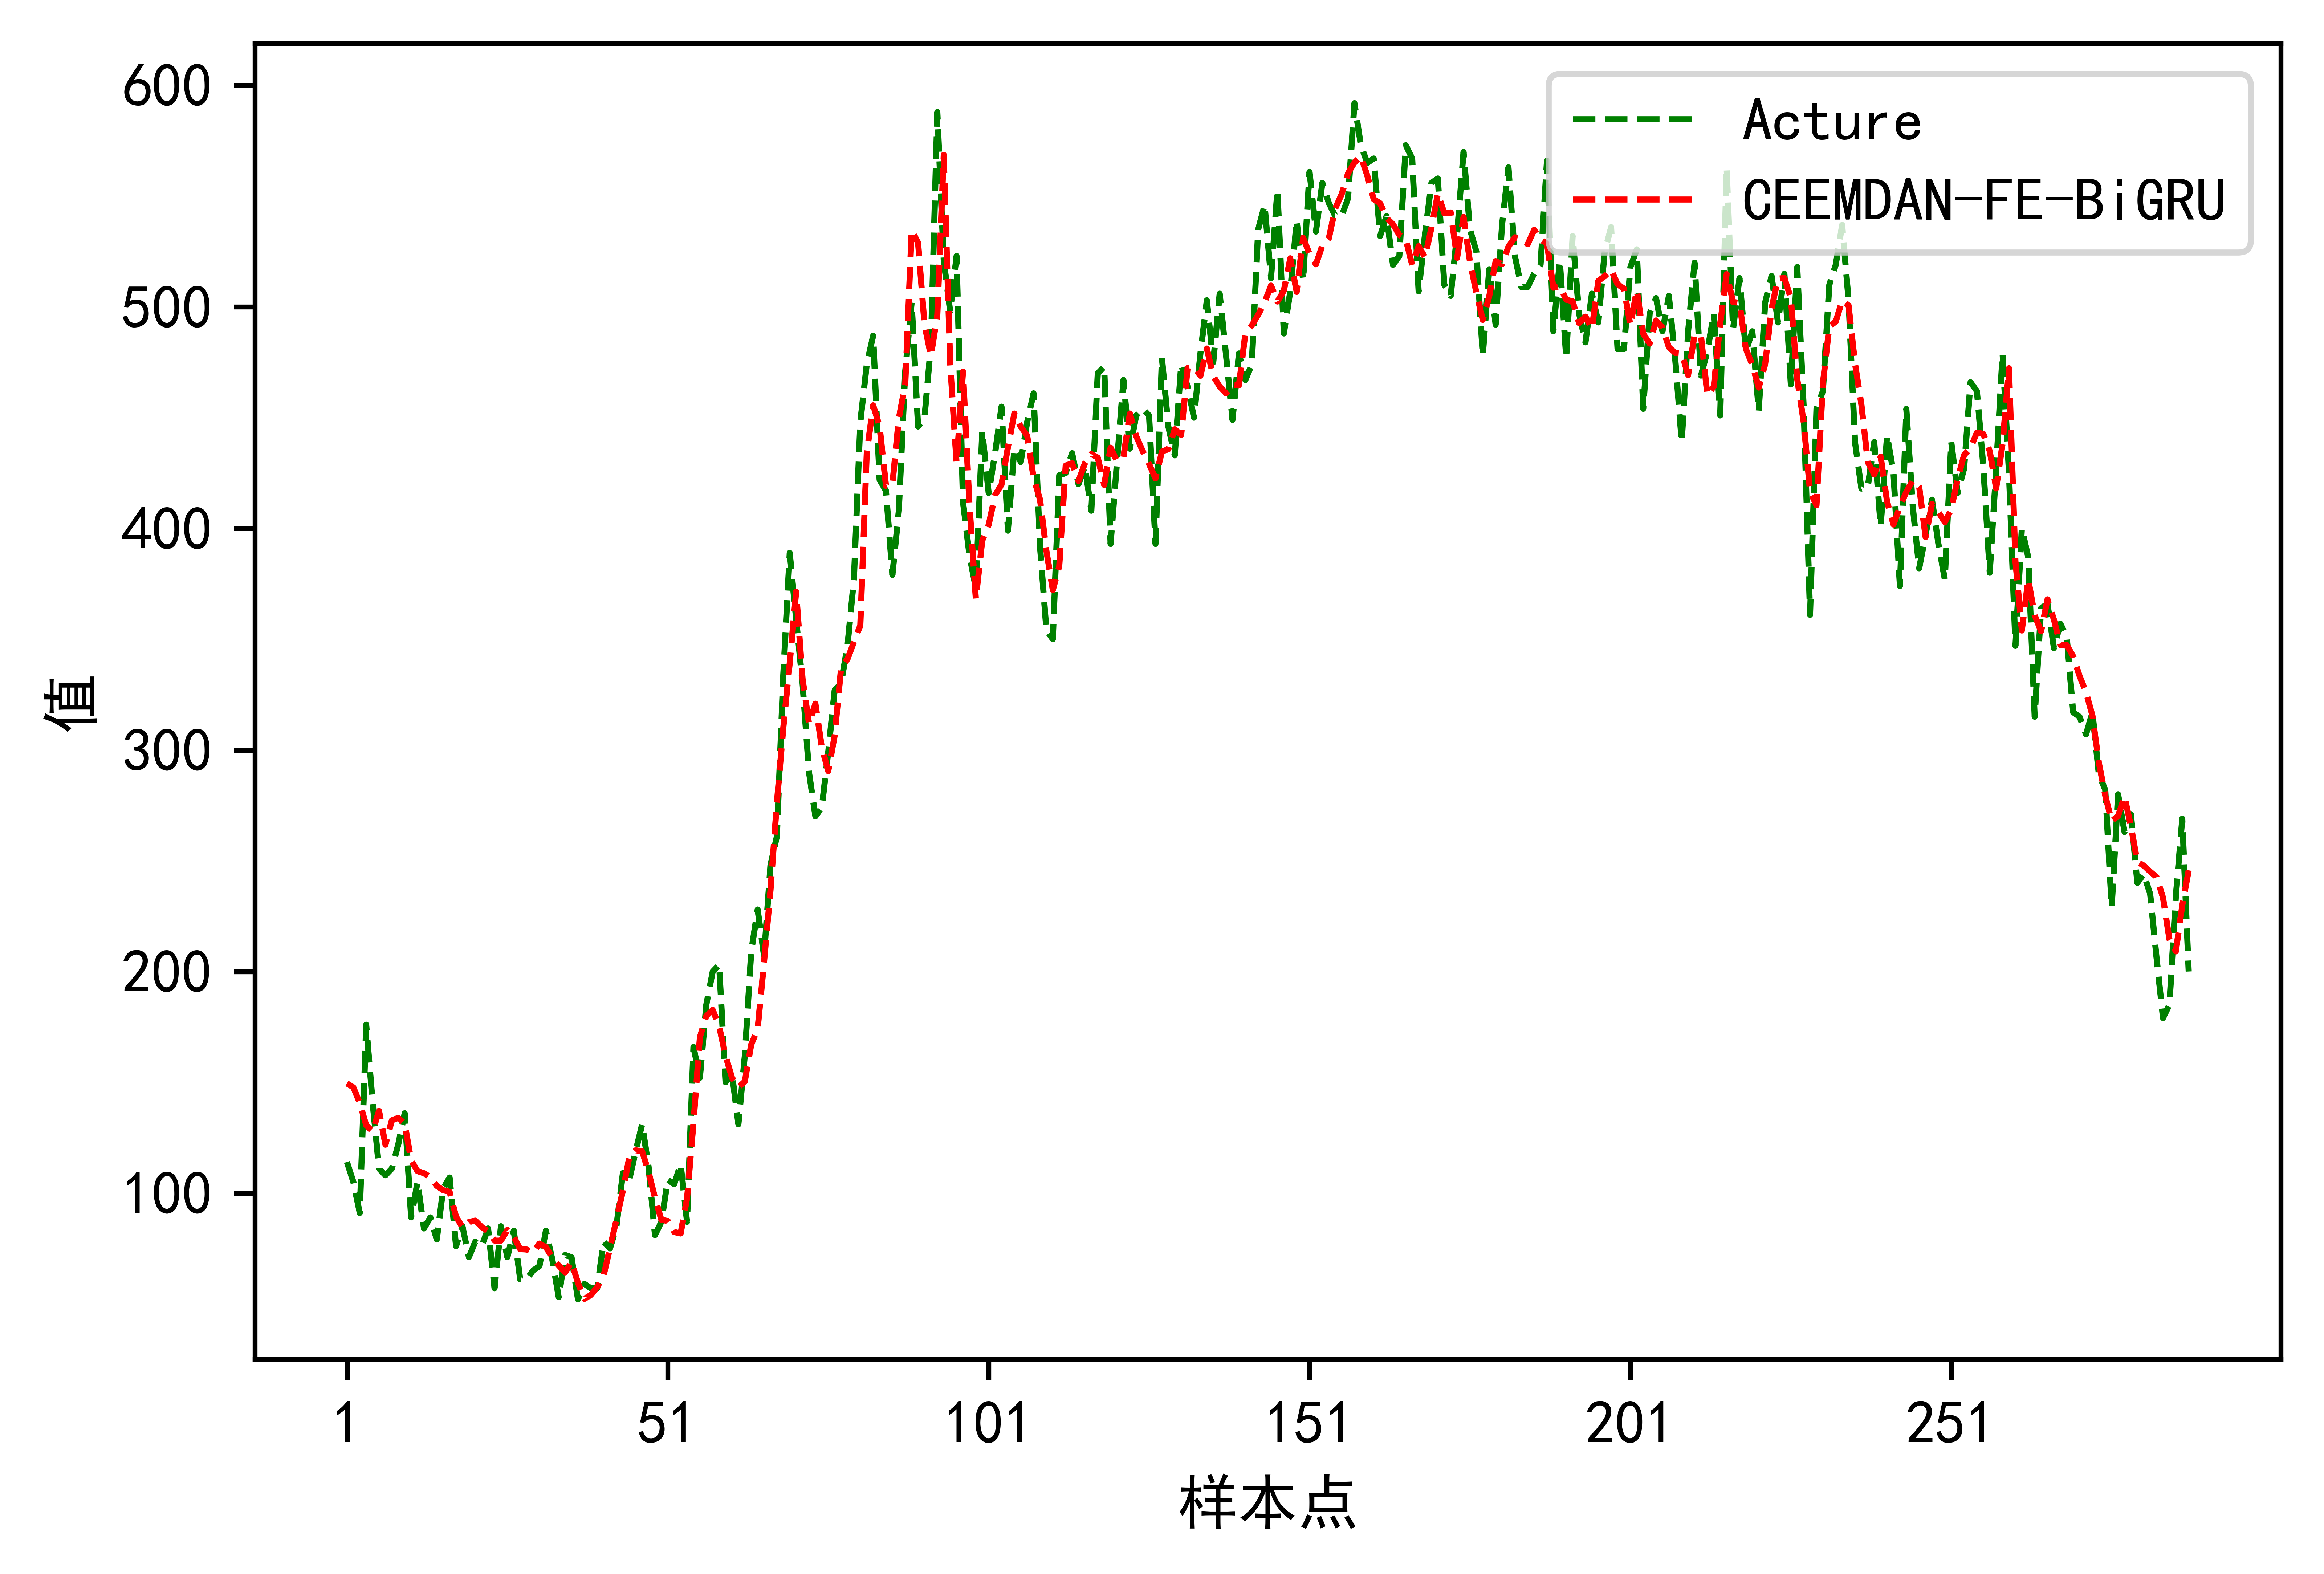

In [18]:
# 测试集
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.figure(figsize=(6,4),dpi=600)
x=range(1, len(mean_pre_test) + 1)
plt.xticks(x[::50])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, mean_actual_test, linestyle="--",color='g',linewidth=1, label='Acture')
plt.plot(x, mean_pre_test,  color='red',linestyle="--",linewidth=1,label='CEEMDAN-FE-BiGRU')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("值",fontsize=10)
# plt.xlim(xmin=600,xmax=700)  #显示600-1000的值   局部放大有利于观察
# plt.savefig('台湾VMD-LSTM震级预测结果图.png')
plt.show()

In [19]:
# #保存预测结果
savemat('结果/ceemdan_fe_bigru_result.mat',{'true':mean_actual_test,'pred':mean_pre_test})